In [1]:
# ### install requested packages
# !pip install contextily
# !pip install statsmodels

# ### download necessary data
# !rm -rf util && mkdir util
# !wget 'https://raw.githubusercontent.com/bz247/TUW_231028/refs/heads/main/util/haversine.py' -O util/haversine.py

# !rm -rf data && mkdir data

Defaulting to user installation because normal site-packages is not writeable
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached pillow-11.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached numpy-2.1.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pyparsing-3.2.0-py3-none

UsageError: Line magic function `%wget` not found.


In [2]:
# ### download the data.zip file from: https://tuwienacat-my.sharepoint.com/:f:/g/personal/bingyu_zhao_tuwien_ac_at/EkhK2y95nU9Pu7jBNSX6zsEBuMzb1rslbH7gBzFF0UsmvQ?e=Tf5iA8
# ### upload it to the data folder
# !unzip data/data.zip -d data

UsageError: Line magic function `%unzip` not found.


In [1]:
### import libraries data analysis
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

### import libraries for plotting
import matplotlib.pyplot as plt

### import libraries for geodata analysis and visualisation
import shapely
import geopandas as gpd
import contextily as ctx
from util import haversine ### user define

### Exercise 1. Descriptive statistics with GPS trajectories
The GPS data are collected from two tram trips in Vienna. Please calculate:
* The total length of each trip (km)
* The time duration of each trip (min)
* The space-mean speed of each trip (km/h)
* The speed variation of each trip (km/h)
* The time-mean speed of these two trips when passing through the Franzensbrücke/Donaukanal (lat: 48.213220952644534, lon 16.391347808889147) in km/h

#### Step 1. Read the data

In [2]:
### read and examine the data
gps_trip1 = pd.read_csv('data/GPS/GPS_trip1.csv')
display(gps_trip1.head())

gps_trip2 = pd.read_csv('data/GPS/GPS_trip2.csv')
display(gps_trip2.tail())

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.009346,48.217988,16.391613,161.423233,208.561432,NaN,NaN,0.032200,104.000000,25.152908,-1.0
1,0.062871,48.217808,16.391954,161.422024,208.559843,NaN,NaN,0.068391,161.578258,25.152908,-1.0
2,0.615973,48.217794,16.391466,161.567802,208.706380,NaN,NaN,0.091663,35.684899,19.581636,-1.0
3,1.338942,48.217795,16.391780,169.688252,216.826347,5.08,174.023438,0.092956,20.746684,48.000000,-1.0
4,2.339968,48.217783,16.391783,160.666523,207.804623,5.43,174.023438,0.099677,4.702867,4.000000,-1.0


,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
604,599.840065,48.218271,16.391482,162.408429,209.546605,0.570046,306.972861,1.985339,4.755811,3.347655,-1.0
605,600.840066,48.218272,16.391478,162.313826,209.452007,0.653264,NaN,1.986094,4.751374,3.353950,-1.0
606,601.840068,48.218279,16.391477,161.217455,208.355633,0.354654,357.561597,1.986398,4.756785,3.346271,-1.0
607,602.840071,48.218281,16.391478,160.761028,207.899201,0.000000,359.143505,1.986398,4.768354,3.329765,-1.0
608,603.840072,48.218281,16.391478,160.761028,207.899201,0.000000,359.143505,NaN,4.793676,3.293207,-1.0


#### Step 2. Visualise the data

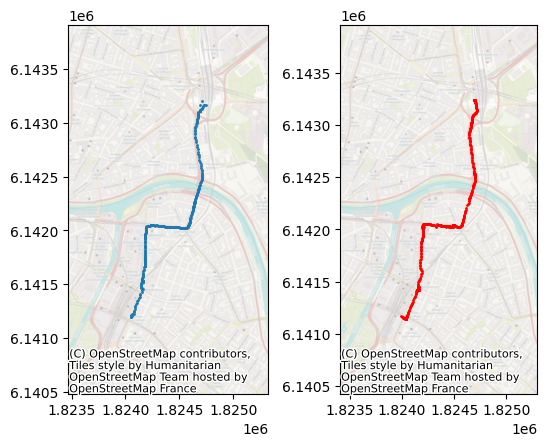

In [3]:
### visualisation 1. plotting the data on a map
fig, ax = plt.subplots(1, 2)

### first trip
gps_trip1 = gpd.GeoDataFrame(gps_trip1, crs='epsg:4326', 
                             geometry=[shapely.geometry.Point(xy) for xy in zip(gps_trip1['Longitude (°)'], gps_trip1['Latitude (°)'])])
gps_trip1 = gps_trip1.to_crs(3857) ### transform coordinate reference system to match the background map
gps_trip1.plot(markersize=1, ax=ax[0])
ax[0].set_xlim([ax[0].get_xlim()[0]*0.9997, ax[0].get_xlim()[1]*1.0003])
ax[0].set_ylim([ax[0].get_ylim()[0]*0.9999, ax[0].get_ylim()[1]*1.0001])
ctx.add_basemap(ax[0], alpha=0.5)

### second trip
gps_trip2 = gpd.GeoDataFrame(gps_trip2, crs='epsg:4326', 
                             geometry=[shapely.geometry.Point(xy) for xy in zip(gps_trip2['Longitude (°)'], gps_trip2['Latitude (°)'])])
gps_trip2 = gps_trip2.to_crs(3857) ### transform coordinate reference system to match the background map
gps_trip2.plot(markersize=1, color='red', ax=ax[1])
ax[1].set_xlim([ax[1].get_xlim()[0]*0.9997, ax[1].get_xlim()[1]*1.0003])
ax[1].set_ylim([ax[1].get_ylim()[0]*0.9999, ax[1].get_ylim()[1]*1.0001])
ctx.add_basemap(ax[1], alpha=0.5)


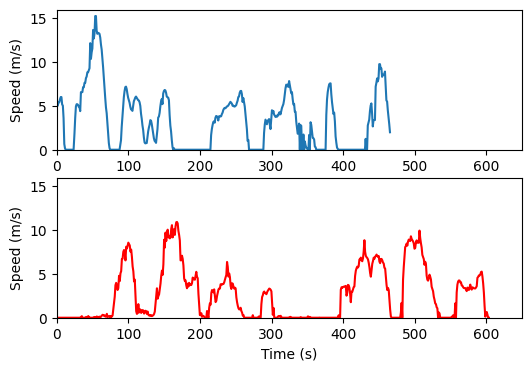

In [5]:
### visualisation 2. plotting the temporal changes of speed
fig, ax = plt.subplots(2, 1, figsize=(6, 4))

### first trip
ax[0].plot(gps_trip1['Time (s)'], gps_trip1['Speed (m/s)'])

### second trip
ax[1].plot(gps_trip2['Time (s)'], gps_trip2['Speed (m/s)'], color='red')

### style
for ax_i in ax:
    ax_i.set_xlim([0, 650])
    ax_i.set_ylim([0, 16])
    ax_i.set_xlabel('Time (s)')
    ax_i.set_ylabel('Speed (m/s)')

#### Step 3. Calculate the summary statistics

In [6]:
# The total length of each trip
trip_1_length = gps_trip1['Distance (km)'].max() - gps_trip1['Distance (km)'].min()
print(f'The length of trip 1 is {trip_1_length:.03f} km')

trip_2_length = gps_trip2['Distance (km)'].max() - gps_trip2['Distance (km)'].min()
print(f'The length of trip 2 is {trip_2_length:.03f} km')

The length of trip 1 is 1.756 km
The length of trip 2 is 1.980 km


In [7]:
# The time duration of each trip
trip_1_time = gps_trip1['Time (s)'].max() - gps_trip1['Time (s)'].min()
trip_1_time = trip_1_time/60
print(f'The length of trip 1 is {trip_1_time:.01f} min')

trip_2_time = gps_trip2['Time (s)'].max() - gps_trip2['Time (s)'].min()
trip_2_time = trip_2_time/60
print(f'The length of trip 2 is {trip_2_time:.01f} min')

The length of trip 1 is 7.8 min
The length of trip 2 is 10.1 min


In [8]:
# The space-mean speed of each trip
trip_1_speed = trip_1_length/(trip_1_time/60)
trip_1_speed_alternative = gps_trip1['Speed (m/s)'].mean() * 3600/1000
print(f'The space-mean speed of trip 1 is {trip_1_speed:.01f} km/h, or {trip_1_speed_alternative:.01f} km/h?')

trip_2_speed = trip_2_length/(trip_2_time/60)
trip_2_speed_alternative = gps_trip2['Speed (m/s)'].mean() * 3600/1000
print(f'The space-mean speed of trip 2 is {trip_2_speed:.01f} km/h, or {trip_2_speed_alternative:.01f} km/h?')

The space-mean speed of trip 1 is 13.6 km/h, or 11.8 km/h?
The space-mean speed of trip 2 is 11.8 km/h, or 9.6 km/h?


In [9]:
# The speed variation of each trip
trip_1_speed_variation = gps_trip1['Speed (m/s)'].std() * 3600/1000
print(f'The speed variation of trip 1 is {trip_1_speed_variation:.01f} km/h')

trip_2_speed_variation = gps_trip2['Speed (m/s)'].std() * 3600/1000
print(f'The speed variation of trip 2 is {trip_2_speed_variation:.01f} km/h')

The speed variation of trip 1 is 12.1 km/h
The speed variation of trip 2 is 10.8 km/h


In [10]:
# The time-mean speed of these two trips when passing through the Franzensbrücke/Donaukanal (lat: 48.213220952644534, lon 16.391347808889147)
bridge_lat, bridge_lon = 48.213220952644534, 16.391347808889147
gps_trip1['bridge_distance'] = haversine.haversine(gps_trip1['Latitude (°)'], gps_trip1['Longitude (°)'], bridge_lat, bridge_lon)
gps_trip2['bridge_distance'] = haversine.haversine(gps_trip2['Latitude (°)'], gps_trip2['Longitude (°)'], bridge_lat, bridge_lon)

# display(gps_trip1.loc[gps_trip1['bridge_distance']<10])
# display(gps_trip2.loc[gps_trip2['bridge_distance']<10])

bridge_speed1 = gps_trip1.loc[gps_trip1['bridge_distance'].idxmin(), 'Speed (m/s)']
bridge_speed2 = gps_trip2.loc[gps_trip2['bridge_distance'].idxmin(), 'Speed (m/s)']
bridge_speed_mean = (bridge_speed1 + bridge_speed2)/2
print(f'The time-mean speed of these two trips when passing through the Franzensbrücke/Donaukanal is {bridge_speed_mean:.01f} km/h')

The time-mean speed of these two trips when passing through the Franzensbrücke/Donaukanal is 6.3 km/h


### Exercise 2. Multiple regression of subway monthly ticket purchase decisions

#### Step 1. Read in the survey data

In [11]:
survey = pd.read_csv('data/survey_data/survey_data.csv')
survey.head()

,choice,transfer_time,waiting_time,discount
0,1,0,6,4
1,1,15,2,4
2,1,0,8,0
3,0,30,8,0
4,0,0,8,0


#### Step 2. Build a logistic regression model

In [12]:
logit = smf.logit(formula='choice ~ transfer_time + waiting_time + discount', data = survey)
results = logit.fit()
print(results.params)
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.512514
         Iterations 6
Intercept        0.786029
transfer_time   -0.019984
waiting_time    -0.150852
discount         0.807390
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49996
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                  0.2231
Time:                        02:34:08   Log-Likelihood:                -25626.
converged:                       True   LL-Null:                       -32986.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

#### Step 3. Plot the results

Text(0, 0.5, 'Choice outcome')

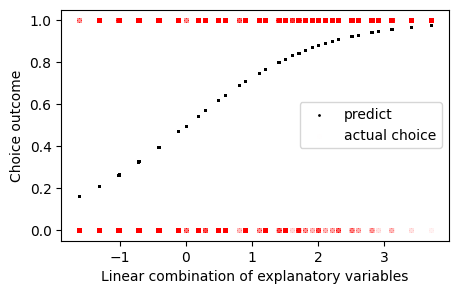

In [13]:
predict = survey.copy()
predict['predict'] = results.predict(predict[['transfer_time', 'waiting_time', 'discount']])
predict['linear'] = results.params['Intercept'] + results.params['transfer_time'] * predict['transfer_time'] +\
                    results.params['waiting_time'] * predict['waiting_time'] +\
                    results.params['discount'] * predict['discount']

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(predict['linear'], predict['predict'], s=1, c='k', label='predict')
ax.scatter(predict['linear'], predict['choice'], s=10, c='r', alpha=0.002, label='actual choice')
ax.legend()
ax.set_xlabel('Linear combination of explanatory variables')
ax.set_ylabel('Choice outcome')